In [1]:
import numpy as np
import pandas as pd
import time
import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from boris_util import *

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



import multiprocessing

# Importing the dataset

We'll read in the data again and combine all abnormalities

In [3]:
dataset = read_and_combine_data('453_923_bundle_archive', read_noisy_data=False)
print(dataset.shape)
dataset.head()

processed 100.00%
(436, 4)


signal  sampling_rate  \
0  [2.2960085e-05, -0.00012982322, -0.00018070513...          22050   
1  [-1.0927635e-05, 1.0574424e-06, 2.108567e-06, ...          22050   
2  [3.728857e-05, -0.0001664555, -7.4023155e-05, ...          22050   
3  [-0.0027429417, -0.0066496185, -0.0049779303, ...          22050   
4  [0.000106223946, 0.0015002153, 0.0097254915, 0...          22050   

   audio_length     label  
0           9.0  artifact  
1           9.0  artifact  
2           9.0  artifact  
3           9.0  artifact  
4           9.0  artifact

In [4]:
def relabel(label):
    if (label == "normal"):
        return "normal"
    else:
        return "abnormal"
dataset['label'] = dataset['label'].apply(relabel)

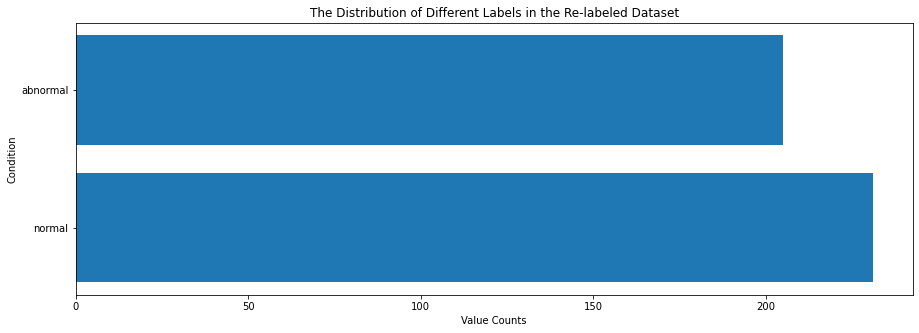

In [5]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Re-labeled Dataset")
plt.show()

Let's split our data now into a simple train/test stratified split

In [6]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, stratify=dataset['label'], random_state=1)
print(train_dataset.shape)
print(test_dataset.shape)

(305, 4)
(131, 4)


And look at the data. As we can see each row contains:
* A signal (which is a numpy array)
* A sampling rate (they all have the same sampling rate but it's useful to have that information handy)
* The audio_length in seconds
* The label which is the target

In [7]:
train_dataset.head()

signal  sampling_rate  \
302  [-0.014594975, -0.016623363, -0.017930867, -0....          22050   
401  [0.00535502, 0.0048318487, 0.0038144102, 0.002...          22050   
311  [-0.0009814408, -0.00052338943, 9.0988244e-05,...          22050   
346  [-0.007578952, -0.011004641, -0.015165693, -0....          22050   
410  [-0.030912954, -0.033952978, -0.035377894, -0....          22050   

     audio_length   label  
302      5.025533  normal  
401      1.724263  normal  
311      3.822766  normal  
346      4.312018  normal  
410      3.167755  normal

## Dataset Augmentation

We won't get very far with the examples we have. There aren't very many of them

Luckily, we can easily augment the dataset by shifting the data and/or adding some noise

In [8]:
DATASET_TARGET = train_dataset.shape[0]
DATASET_TARGET = 1500

In [9]:
# find the label ratios
inverse_counts = 1/train_dataset['label'].value_counts()
probability_counts = inverse_counts/inverse_counts.sum()
probability_counts

normal      0.468852
abnormal    0.531148
Name: label, dtype: float64

In [10]:
# https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6
    
def shift_sound(data, sampling_rate, shift_max, shift_direction='both'):
    shift = np.random.randint(int(shift_max * data.shape[0]))
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data = augmented_data[shift:]
    else:
        augmented_data = augmented_data[:shift]
    return augmented_data

In [11]:
def make_noise(data, noise_factor):
    
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    
    
    return augmented_data

In [12]:
choices = np.random.choice(probability_counts.index, 
                           p=probability_counts.values, 
                           size=(DATASET_TARGET,))
i = 0

# Do this so we don't make a variant of a variant, but keep choosing from the original data
new_dataset = train_dataset.copy()

while new_dataset.shape[0] < DATASET_TARGET:
    choice = choices[i]
    available_instances = train_dataset[train_dataset['label'] == choice]
    selected_row_position = np.random.randint(available_instances.shape[0])
    
    selected_row = available_instances.iloc[selected_row_position]
    
    base_signal = selected_row['signal']
    sampling_rate = selected_row['sampling_rate']
    
    shift_direction = 'both'
    new_signal = shift_sound(base_signal, sampling_rate, (np.random.random()*0.3), shift_direction)
    
        
    if (new_signal.shape[0] > 0):
    
        new_series = pd.Series({'signal' :new_signal, 'sampling_rate': sampling_rate, 'label': choice})
        new_dataset = new_dataset.append(new_series, ignore_index=True)
    
        print(new_dataset.shape, end="\r")
    i+= 1
    
train_dataset = new_dataset

Now let's define a class which will convert the signals into Mel spectrograms

In [13]:
class MelEncoder:
    
    '''
        This transformer takes an audio signal and employes librosa
        to transform the audio signal into a Mel-frequency spectrogram.
        
        The transformation transforms the audio signal from samples in a 
        time domain, to frequencies over each time window. The frequencies
        are then collected into buckets which are easily distinguished by
        human hearing
        
        The code here is largely dervied from functions in 
        https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
        
        I took those and turned them into a class for an easy interface
    '''
    
    def __init__(self, 
                 flatten=True, 
                 n_fft=2048, 
                 hop_length=512, 
                 n_mels=128, 
                 sampling_rate=22050.0, 
                 n_windows=1000, 
                 verbose=0):
        
        
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.sampling_rate = sampling_rate
        self.n_windows = n_windows
        self.verbose = verbose
        
        
        self.flatten = flatten
        
    ################################################################################################
    def fit(self, X, y=None):
        '''
            This method doesn't do much except initialize a private variables
        '''
        self.longest_signal_length = None
        
        
    ################################################################################################    
    def _signal_to_mel_spectrogram(self, signal):
        '''
            This method accepts an audio signal as a list of measurements
            and returns the signal broken up into the Mel scale.
            
            If n_windows was specified, the signal is broken up into
            n_windows. Otherwise, the signal is broken up based
            on hop_length and is broken into however many windows
            can be fitted using hop_length
        '''
        
        
        if (self.n_windows is not None):
            hop_length = signal.shape[0]//self.n_windows
        else:
            hop_length = self.hop_length
        S = librosa.feature.melspectrogram(signal, 
                                           sr=self.sampling_rate, 
                                           n_fft=self.n_fft, 
                                           hop_length=hop_length, 
                                           n_mels=self.n_mels)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return S_DB
    
    ################################################################################################
    def _create_spectrogram_list(self, X):
        '''
            This method accepts a an array of signals 
            (each signal is a list of measurements)
            and returns a list of the Mel spectrograms
            corresponding to each signal
        '''
        
        spectrogram_list = []
        
        
        for i, signal in enumerate(X):
                mel_spectrogram = self._signal_to_mel_spectrogram(signal)
                spectrogram_list.append(mel_spectrogram)
                if (self.verbose):
                    print(f"processed: {round(100*i/X.shape[0], 2)}%", end="\r")
                    
                
        print(f"processed: {round(100*i/X.shape[0], 2)}%")
        
        return spectrogram_list
    
    ################################################################################################
    def _find_longest_signal_length(self, spectrogram_list):
        '''
            This method accepts a spectrogram list and finds
            the length of the longest spectrogram
        '''
        
        max_length = 0
        for mel_spectrogram in spectrogram_list:
            if (mel_spectrogram.shape[1] > max_length):
                max_length = mel_spectrogram.shape[1]

        return max_length
    
    ################################################################################################
    def _build_mel_spectrogram_stack(self, spectrogram_list):
        '''
            This method accepts a list of spectrograms and
            returns a numpy array which is a stack of those
            spectrograms of shape (len(spectrogram_list), n_mels, N)
            where N is the length of the longest spectrogram
            in the list. 
            Empty spots are filled with -80 
            (the default value for no signal)
        '''
        
        X_transformed = np.full(shape=(len(spectrogram_list), self.n_mels, self.longest_signal_length),
                                fill_value=-80.0)
        
        for i, mel_spectrogram in enumerate(spectrogram_list):
            if (mel_spectrogram.shape[1] <= self.longest_signal_length):
                X_transformed[i, :, -mel_spectrogram.shape[1]:] = mel_spectrogram[:, :]
            else:
                X_transformed[i, :, :] = mel_spectrogram[:, -self.longest_signal_length:]
                
        return X_transformed
    
    
    
    ################################################################################################
    def transform(self, X):
        '''
            This method accepts an array of audio signals and returns
            a numpy array of spectrograms 
            
            The spectrogram array returns with shape (len(X), n_mels, N) 
            where N is the length of the longest spectrogram, if flatten 
            was set to True
            
            The spectrogram array returns with shape (len(X), n_mels X N) 
            where N is the length of the longest spectrogram, if flatten 
            was set to False
            
            
        '''
        
        spectrogram_list = self._create_spectrogram_list(X)
        
        if (self.longest_signal_length is None):
            self.longest_signal_length = self._find_longest_signal_length(spectrogram_list)
            
        X_transformed = self._build_mel_spectrogram_stack(spectrogram_list)
        
        
        if (self.flatten):
            return X_transformed.reshape(X_transformed.shape[0], -1)
        else:
            return X_transformed
        
    ################################################################################################ 
    def fit_transform(self, X, y=None):
        '''
            This method accepts an array of audio signals and returns
            a numpy array of spectrograms 
            
            The spectrogram array returns with shape (len(X), n_mels, N) 
            where N is the length of the longest spectrogram, if flatten 
            was set to True
            
            The spectrogram array returns with shape (len(X), n_mels X N) 
            where N is the length of the longest spectrogram, if flatten 
            was set to False
        '''
        return self.fit(X).transform(X)

Let's employ out encoder and transform the data. Since we'll be using basic machine learning models we will flatten the output

In [14]:
my_encoder = MelEncoder(n_mels=128, n_windows=1000, verbose=1)
my_encoder.fit(train_dataset['signal'])

X_train_mel = my_encoder.transform(train_dataset['signal'])
X_train_mel.shape

processed: 99.93%


(1500, 135296)

In [15]:
X_test_mel = my_encoder.transform(test_dataset['signal'])
X_test_mel.shape

processed: 99.24%


(131, 135296)

## PCA

Since there is a very small collection of data points, we can embed them in a much smaller dimensional space without losing any of the variance.

Let's scale the data:

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
%%time 
my_mmscaler = MinMaxScaler()

X_train_mel = my_mmscaler.fit_transform(X_train_mel)
X_test_mel = my_mmscaler.transform(X_test_mel)

CPU times: user 2.49 s, sys: 654 ms, total: 3.15 s
Wall time: 2.18 s


And employ PCA to reduce the number of dimensions to the smaller of the row number or column number. In this case the data is <font color="red">$2,000 \times 134,400$ in size, so it will be reduced to $2,000 \times 2,000$

In [18]:
%%time 

component_number = 0.95
#component_number = min(*X_train_mel.shape)
my_pca = PCA(n_components=component_number, svd_solver='auto')
my_pca.fit(X_train_mel)

CPU times: user 12min 2s, sys: 28 s, total: 12min 30s
Wall time: 1min 18s


PCA(n_components=0.95)

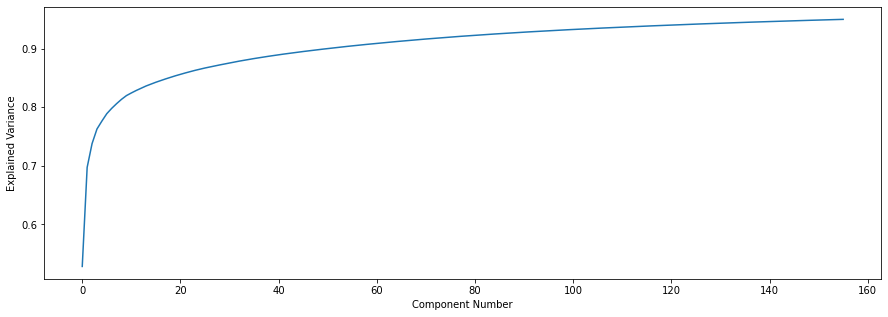

In [19]:
plt.figure(figsize=(15,5))
plt.plot(my_pca.explained_variance_ratio_.cumsum())
plt.xlabel("Component Number")
plt.ylabel("Explained Variance")
plt.show()

In [20]:
X_train_mel = my_pca.transform(X_train_mel)
X_test_mel = my_pca.transform(X_test_mel)

In [21]:
X_train_mel.shape

(1500, 156)

In [22]:
X_test_mel.shape

(131, 156)

Let's encode the categorical targets into labels

In [23]:
condition_label_encoder = LabelEncoder()


y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
y_test = condition_label_encoder.transform(test_dataset['label'])

print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(1500, 156) (131, 156)
(1500,) (131,)


## Basic Model - Logistic Regression

Let's start by establishing a baseline performance. I'm going to load the data into a logistic regression and see how it performs out-of-the-box

In [24]:
%%time

my_logit = LogisticRegression(solver='saga', random_state=1).fit(X_train_mel, y_train)
train_acc = my_logit.score(X_train_mel, y_train)
test_acc = my_logit.score(X_test_mel, y_test)

CPU times: user 198 ms, sys: 14.5 ms, total: 213 ms
Wall time: 214 ms


In [25]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 78.0%
The test accuracy is 64.12%


Extremely suspicious results. There is clearly a very large sign of overfitting here. We can look at the confusion matrix, and normalize across the predictions

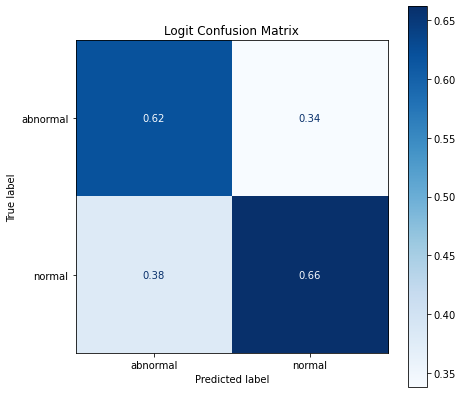

In [26]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='pred',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

Certainly we see an improvement over the non-augmented data where if our model predicted an example to be "normal" it will be right 58% of the time, and wrong 48% of the time

Let's run a grid search and see if we can find a better configuration

In [27]:
CV_FOLD = 5

In [28]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [2**i for i in range(-17, 18)]}
my_estimator = LogisticRegression(solver='saga', random_state=1)

my_logit_gs = GridSearchCV(my_estimator, 
                           param_grid, 
                           cv=CV_FOLD, 
                           verbose=1, 
                           n_jobs=multiprocessing.cpu_count()-2)

In [29]:
%%time
my_logit_gs.fit(X_train_mel, y_train);

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 350 out of 350 | elapsed:    8.9s finished


CPU times: user 576 ms, sys: 190 ms, total: 766 ms
Wall time: 9.36 s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1, solver='saga'),
             n_jobs=10,
             param_grid={'C': [7.62939453125e-06, 1.52587890625e-05,
                               3.0517578125e-05, 6.103515625e-05,
                               0.0001220703125, 0.000244140625, 0.00048828125,
                               0.0009765625, 0.001953125, 0.00390625, 0.0078125,
                               0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1,
                               2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
                               4096, ...],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [30]:
my_logit_gs.best_params_

{'C': 4, 'penalty': 'l1'}

In [31]:
train_acc = my_logit_gs.score(X_train_mel, y_train)
test_acc = my_logit_gs.score(X_test_mel, y_test)

In [32]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 78.07%
The test accuracy is 64.12%


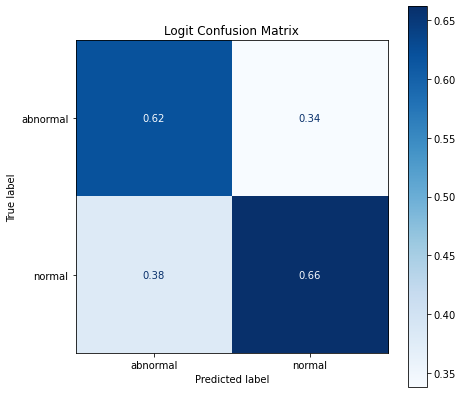

In [33]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='pred',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

Our results have not improved much over the cross validation

In [34]:
y_proba = my_logit_gs.predict_proba(X_test_mel)

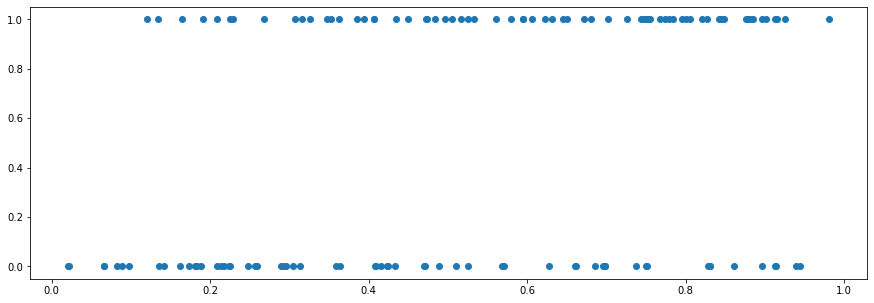

In [35]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], y_test)
plt.show();

We are going to run other models for comparison purposes. Let's create a dataframe that will store these results for us. That way we can later easily perform a statistical analysis on the models and compare their performances visually

In [36]:
total_run_times_dataframe = pd.DataFrame({"model": [],
                                          "dataset": [],
                                          "score": []})
total_run_times_dataframe

Empty DataFrame
Columns: [model, dataset, score]
Index: []

In [37]:
current_row = total_run_times_dataframe.shape[0]
total_run_times_dataframe.loc[current_row, 'model'] = "Logistic Regression"
total_run_times_dataframe.loc[current_row, 'dataset'] = "test"
total_run_times_dataframe.loc[current_row, 'score'] = test_acc

current_row = total_run_times_dataframe.shape[0]
total_run_times_dataframe.loc[current_row, 'model'] = "Logistic Regression"
total_run_times_dataframe.loc[current_row, 'dataset'] = "train"
total_run_times_dataframe.loc[current_row, 'score'] = train_acc
total_run_times_dataframe

model dataset     score
0  Logistic Regression    test  0.641221
1  Logistic Regression   train  0.780667

### Let's write a function for all that

The function will perform grid search, will output confusion matrices for us, and will update our dataframe of results

In [38]:
def run_model(estimator, param_grid, X_train_mel, y_train, X_test_mel, y_test, total_run_times_dataframe, model_name, search_type='gs'):
    
    print("Fitting model")
    if (search_type ==  'gs'):
        my_gs = GridSearchCV(estimator, param_grid, cv=CV_FOLD, verbose=1, n_jobs=multiprocessing.cpu_count()-2)
    elif (search_type == 'random'):
        my_gs = RandomizedSearchCV(estimator, 
                                   param_grid, 
                                   cv=CV_FOLD, 
                                   verbose=1, 
                                   n_jobs=multiprocessing.cpu_count()-2,
                                   n_iter=1000)
    else:
        print("Search type has not been defined, must be either 'gs' or 'random'")
        my_gs = None
        
    my_gs.fit(X_train_mel, y_train);
    
    train_acc = my_gs.score(X_train_mel, y_train)
    test_acc = my_gs.score(X_test_mel, y_test)
    
    print(f"The training accuracy is {round(train_acc*100,2)}%")
    print(f"The test accuracy is {round(test_acc*100,2)}%")
    print(f"Optimal Parameters are: {my_gs.best_params_}")
    
    
    figure, ax = plt.subplots(figsize=(7, 7))
    disp = plot_confusion_matrix(my_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='pred',
                             ax=ax)
    disp.ax_.set_title(f"{model_name} Confusion Matrix")
    plt.show()
    
    
    try:
        y_proba = my_gs.predict_proba(X_test_mel)

        plt.figure(figsize=(15, 5))    
        plt.scatter(y_proba[:, 1], y_test)
        plt.xlabel("Probabilities")
        plt.ylabel("True Class")
        plt.title(f"Probabilities Predicted by {model_name} versus the True Classes")
        plt.show();
    except AttributeError:
        print("Model cannot output probabilities")
    
    
    current_row = total_run_times_dataframe.shape[0]
    total_run_times_dataframe.loc[current_row, 'model'] = model_name
    total_run_times_dataframe.loc[current_row, 'dataset'] = "test"
    total_run_times_dataframe.loc[current_row, 'score'] = test_acc

    current_row = total_run_times_dataframe.shape[0]
    total_run_times_dataframe.loc[current_row, 'model'] = model_name
    total_run_times_dataframe.loc[current_row, 'dataset'] = "train"
    total_run_times_dataframe.loc[current_row, 'score'] = train_acc
    total_run_times_dataframe
    
    
    
    
    
    

Let's test that it works on the logistic regression and provides the same results as before:

Fitting model
Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 320 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done 350 out of 350 | elapsed:    8.9s finished


The training accuracy is 78.07%
The test accuracy is 64.12%
Optimal Parameters are: {'C': 4, 'penalty': 'l1'}


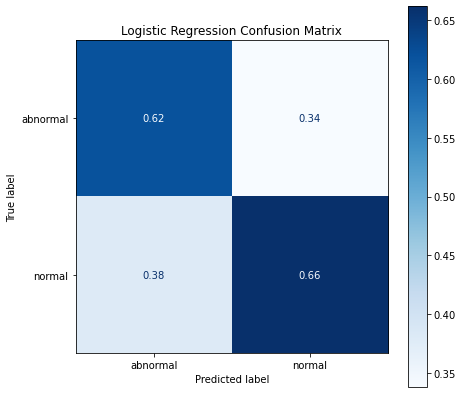

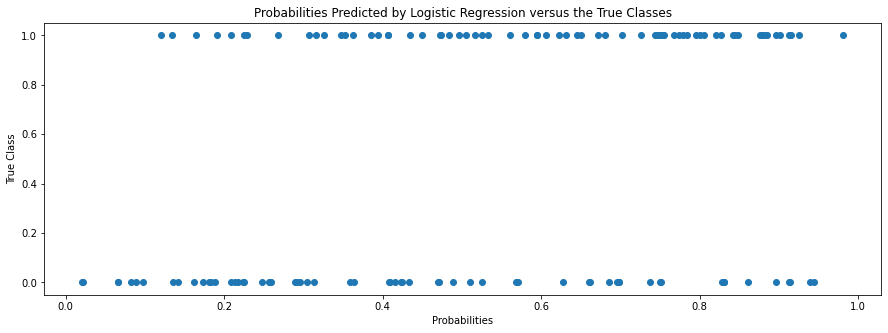

model dataset     score
0  Logistic Regression    test  0.641221
1  Logistic Regression   train  0.780667
2  Logistic Regression    test  0.641221
3  Logistic Regression   train  0.780667

In [39]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [2**i for i in range(-17, 18)]}

run_model(LogisticRegression(solver='saga', random_state=1), 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "Logistic Regression")

total_run_times_dataframe

## Basic Model - Support Vector Machine

We can also explore how well an optimized SVM will perform on our data. We will explore several regularization levels as well as several different out-of-the-box kernels available:

Fitting model
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   14.5s
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:   18.8s finished


The training accuracy is 99.6%
The test accuracy is 63.36%
Optimal Parameters are: {'C': 100, 'kernel': 'rbf'}


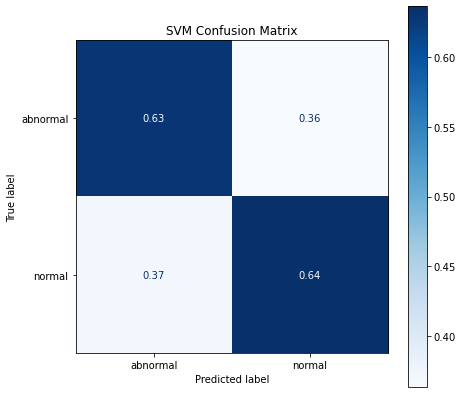

Model cannot output probabilities


model dataset     score
0  Logistic Regression    test  0.641221
1  Logistic Regression   train  0.780667
2  Logistic Regression    test  0.641221
3  Logistic Regression   train  0.780667
4                  SVM    test  0.633588
5                  SVM   train  0.996000

In [40]:
param_grid = {'C': [10**i for i in range(-7, 8)],
              'kernel': ['poly', 'rbf', 'sigmoid', 'linear']}
my_estimator = SVC(max_iter=1000, probability=False, random_state=1)



run_model(my_estimator, 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "SVM")

total_run_times_dataframe

This performance seems on-par with the logistic regression. We would need to repeat this experiment many times to see if there is a statistically significant difference in performance

## Basic Model - KNN

We can also explore the performance for KNN. KNN will search for the most similar spectrograms and use those to infer the new spectrogram example.

We're going to experiment with many configurations for the neighbour number, as well as for the method of distance calculation. We're exploring both uniform distance calculations (i.e. the 5 closest neighbours simply vote on the identity of the new example), as well as distance weighted (i.e. the 5 closest neighbours vote is weighted by their distance, further neighbours get a more discounted vote).

Fitting model
Fitting 5 folds for each of 116 candidates, totalling 580 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done 580 out of 580 | elapsed:   10.2s finished


The training accuracy is 100.0%
The test accuracy is 63.36%
Optimal Parameters are: {'n_neighbors': 4, 'weights': 'distance'}


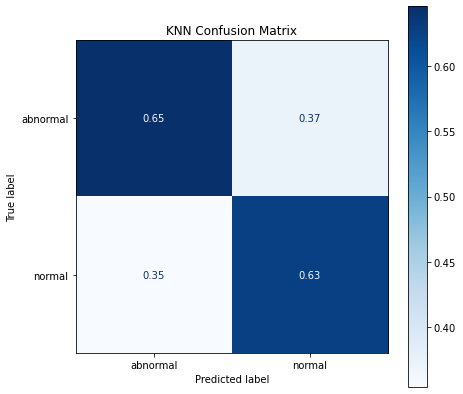

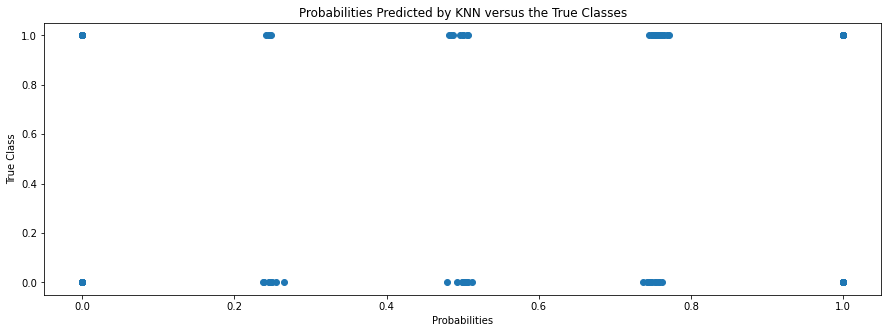

model dataset     score
0  Logistic Regression    test  0.641221
1  Logistic Regression   train  0.780667
2  Logistic Regression    test  0.641221
3  Logistic Regression   train  0.780667
4                  SVM    test  0.633588
5                  SVM   train  0.996000
6                  KNN    test  0.633588
7                  KNN   train  1.000000

In [41]:
param_grid = {'n_neighbors': [i for i in range(3,10)] + \
                             [i for i in range(10, 100, 5)] + \
                             [i for i in range(100, X_train_mel.shape[0]//2, 20)],
              'weights': ['uniform', 'distance']}

my_estimator = KNN()



run_model(my_estimator, 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "KNN")

total_run_times_dataframe

## Basic Model - Decision Tree

As another baseline, I will train a decision tree on the data. We're going to experiment with the maximum depth the tree can grow to (limiting the number of features it can explore), the maximum features each split sees (prevents the tree from focusing on only a few features) and the minimum samples per leaf (prevents overfitting by forcing the tree to build larger regions containing multiple examples).

Fitting model
Fitting 5 folds for each of 1140 candidates, totalling 5700 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 1200 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done 1700 tasks      | elapsed:   14.3s
[Parallel(n_jobs=10)]: Done 2800 tasks      | elapsed:   29.2s
[Parallel(n_jobs=10)]: Done 4600 tasks      | elapsed:   51.2s
[Parallel(n_jobs=10)]: Done 5681 out of 5700 | elapsed:  1.1min remaining:    0.2s
[Parallel(n_jobs=10)]: Done 5700 out of 5700 | elapsed:  1.1min finished


The training accuracy is 96.33%
The test accuracy is 61.07%
Optimal Parameters are: {'max_depth': 16, 'max_features': 0.4, 'min_samples_leaf': 2}


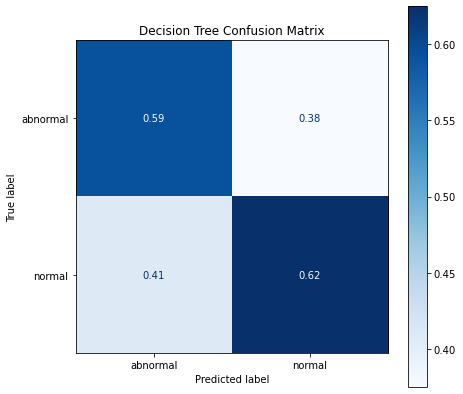

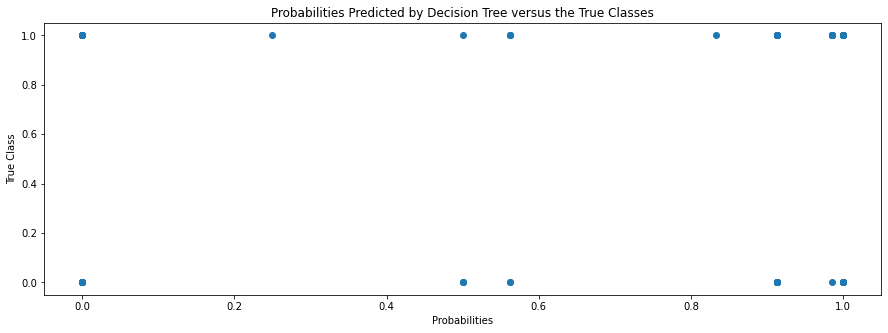

CPU times: user 4 s, sys: 358 ms, total: 4.36 s
Wall time: 1min 5s


model dataset     score
0  Logistic Regression    test  0.641221
1  Logistic Regression   train  0.780667
2  Logistic Regression    test  0.641221
3  Logistic Regression   train  0.780667
4                  SVM    test  0.633588
5                  SVM   train  0.996000
6                  KNN    test  0.633588
7                  KNN   train  1.000000
8        Decision Tree    test  0.610687
9        Decision Tree   train  0.963333

In [42]:
%%time 

my_estimator = DecisionTreeClassifier(random_state=1)
param_grid = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)]}



run_model(my_estimator, 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "Decision Tree")

total_run_times_dataframe

Neither KNN nor the decision tree seem to provide comparable performance to logistic regression or SVM. Again, we will later on verify this using the appropriate statistical analysis.

## Advanced Model - Random Forest

Decision trees performed especially poorly in the previous section. However, their performance can be improved by different ensemble methods. The easiest method to explore is the random forest, where a collection of trees is averaged out.

What makes the random forest random is that each tree only sees a random bootstrapped subsample of the data. Thus outliers are only seen by some trees, but the trend in the data are seen by almost all trees.

Fitting model
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   41.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  4.2min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  8.2min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 10.7min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 13.9min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 17.1min
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed: 17.3min finished


The training accuracy is 100.0%
The test accuracy is 64.12%
Optimal Parameters are: {'n_estimators': 60, 'min_samples_leaf': 2, 'max_features': 0.8, 'max_depth': 76}


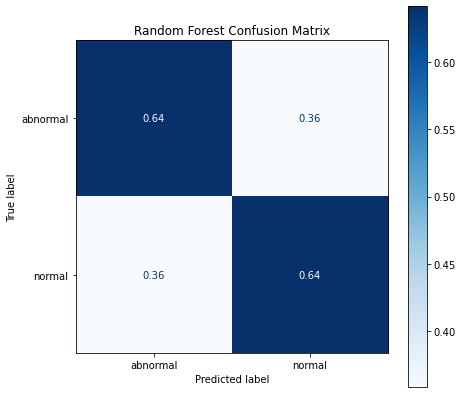

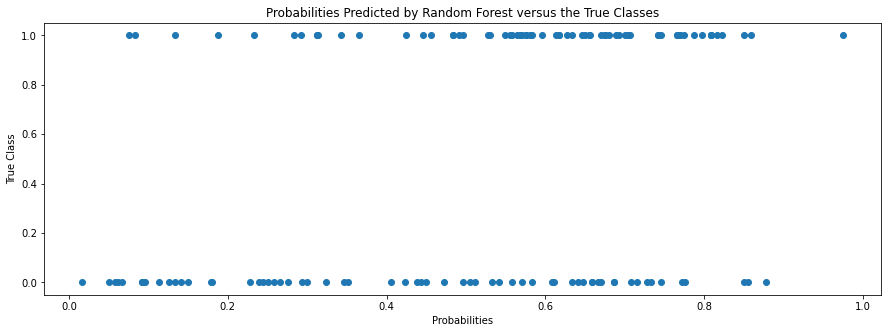

model dataset     score
0   Logistic Regression    test  0.641221
1   Logistic Regression   train  0.780667
2   Logistic Regression    test  0.641221
3   Logistic Regression   train  0.780667
4                   SVM    test  0.633588
5                   SVM   train  0.996000
6                   KNN    test  0.633588
7                   KNN   train  1.000000
8         Decision Tree    test  0.610687
9         Decision Tree   train  0.963333
10        Random Forest    test  0.641221
11        Random Forest   train  1.000000

In [43]:
param_grid = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)],
              'n_estimators': [i*10 for i in range(1,10, 5)]}

my_estimator = RandomForestClassifier(random_state=1)

run_model(my_estimator, 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "Random Forest",
          search_type='random')

total_run_times_dataframe

Interestingly, it seems that employing a random forest did improve the accuracy that can be obtained from decision trees, but it is still inferior to the performance provided by SVM and logistic regression.

## Advanced Model - Gradient Boosting

A more powerful way of improving performance in decision trees is the use of Gradient Boosting. In this case, trees are not averaged out but are built in sequence. Each tree makes the ensemble slightly better by correcting errors encountered so far.

I will employ eXtreme Gradient Boosting (XGBoost) due to its quick implementation and thus faster training time.

Fitting model
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   19.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   50.9s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  3.8min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  5.0min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  6.5min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  8.3min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 10.0min
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed: 10.1min finished


The training accuracy is 100.0%
The test accuracy is 65.65%
Optimal Parameters are: {'subsample': 0.8, 'n_estimators': 90, 'min_child_weight': 2, 'max_depth': 106}


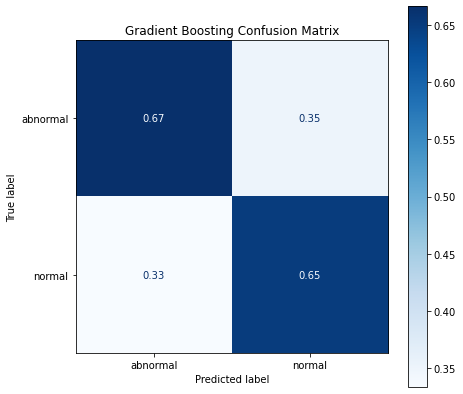

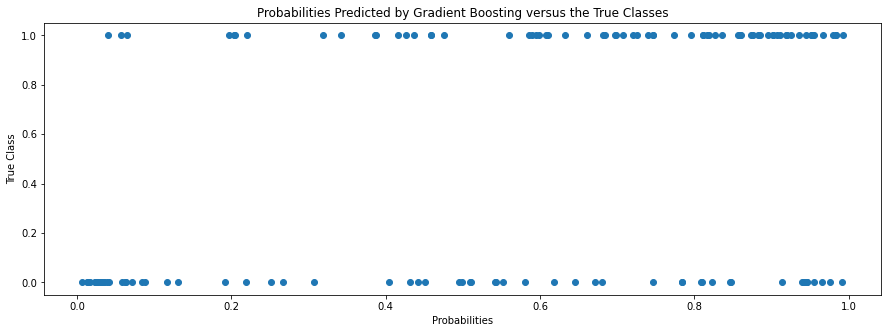

model dataset     score
0   Logistic Regression    test  0.641221
1   Logistic Regression   train  0.780667
2   Logistic Regression    test  0.641221
3   Logistic Regression   train  0.780667
4                   SVM    test  0.633588
5                   SVM   train  0.996000
6                   KNN    test  0.633588
7                   KNN   train  1.000000
8         Decision Tree    test  0.610687
9         Decision Tree   train  0.963333
10        Random Forest    test  0.641221
11        Random Forest   train  1.000000
12    Gradient Boosting    test  0.656489
13    Gradient Boosting   train  1.000000

In [44]:
param_grid = {'min_child_weight': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'subsample': [i/10 for i in range(2, 11, 2)],
              'n_estimators': [i*10 for i in range(1,11, 2)]}
my_estimator = XGBClassifier(learning_rate=0.1, random_state=1)

run_model(my_estimator, 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "Gradient Boosting",
          search_type='random')

total_run_times_dataframe

The results again show an improvement over a single decision tree, but are not enough to perform better than a logistic regression or SVM.

## Repeat the process for different splits

All of the measurements we have are for a single train/test split. However, we would like to have a clearer image of the how the models compare on unseen data. Therefore, we will create a few functions that will encapsulate the workflow we have performed so far, and then repeat the process for many different splits

Once we have observations for 30 splits, we will run a [Tukey's Test for Post-Hoc Analysis](https://aaronschlegel.me/tukeys-test-post-hoc-analysis.html) to see which methodologies indeed provide significantly different results

In [45]:
def run_model(estimator, param_grid, X_train_mel, y_train, X_test_mel, y_test, total_run_times_dataframe, model_name, verbose=0, core_number=1, search_type="gs"):
    
    if (verbose):
        print("Fitting model")
        
    if (search_type ==  'gs'):
        my_gs = GridSearchCV(estimator, param_grid, cv=CV_FOLD, verbose=1, n_jobs=multiprocessing.cpu_count()-2)
    elif (search_type == 'random'):
        my_gs = RandomizedSearchCV(estimator, 
                                   param_grid, 
                                   cv=CV_FOLD, 
                                   verbose=1, 
                                   n_jobs=multiprocessing.cpu_count()-2,
                                   n_iter=1000)
    else:
        print("Search type has not been defined, must be either 'gs' or 'random'")
        my_gs = None
    my_gs.fit(X_train_mel, y_train);
    
    train_acc = my_gs.score(X_train_mel, y_train)
    test_acc = my_gs.score(X_test_mel, y_test)
    
    if (verbose):
        print(f"The training accuracy is {round(train_acc*100,2)}%")
        print(f"The test accuracy is {round(test_acc*100,2)}%")
    
    print(f"Optimal Parameters are: {my_gs.best_params_}")

    if (verbose):
    
        figure, ax = plt.subplots(figsize=(7, 7))
        disp = plot_confusion_matrix(my_gs, X_test_mel, y_test,
                                 display_labels=condition_label_encoder.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='pred',
                                 ax=ax)
        disp.ax_.set_title(f"{model_name} Confusion Matrix")
        plt.show()

        print(classification_report(y_test, my_gs.predict(X_test_mel)))
        
        try:
            y_proba = my_gs.predict_proba(X_test_mel)

            plt.figure(figsize=(15, 5))    
            plt.scatter(y_proba[:, 1], y_test)
            plt.xlabel("Probabilities")
            plt.ylabel("True Class")
            plt.title(f"Probabilities Predicted by {model_name} versus the True Classes")
            plt.show();
        except AttributeError:
            print("This model does not support probabilities")
    
    current_row = total_run_times_dataframe.shape[0]
    total_run_times_dataframe.loc[current_row, 'model'] = model_name
    total_run_times_dataframe.loc[current_row, 'dataset'] = "test"
    total_run_times_dataframe.loc[current_row, 'score'] = test_acc

    current_row = total_run_times_dataframe.shape[0]
    total_run_times_dataframe.loc[current_row, 'model'] = model_name
    total_run_times_dataframe.loc[current_row, 'dataset'] = "train"
    total_run_times_dataframe.loc[current_row, 'score'] = train_acc
    total_run_times_dataframe
    

Create another function for pre-processing. Notice that given more time for this project, I would incorporate the PCA and Mel Encoder into a pipeline for a proper workflow over the cross-validation. However, due to time constraints, I will pre-process the data first, and then perform cross validation

In [46]:
def increase_dataset(the_dataset):
    inverse_counts = 1/the_dataset['label'].value_counts()
    probability_counts = inverse_counts/inverse_counts.sum()
    probability_counts
    
    choices = np.random.choice(probability_counts.index, 
                               p=probability_counts.values, 
                               size=(DATASET_TARGET,))
    i = 0
    
    new_dataset = the_dataset.copy()
    
    while new_dataset.shape[0] < DATASET_TARGET:
        choice = choices[i]
        available_instances = the_dataset[the_dataset['label'] == choice]
        selected_row_position = np.random.randint(available_instances.shape[0])

        selected_row = available_instances.iloc[selected_row_position]

        base_signal = selected_row['signal']
        sampling_rate = selected_row['sampling_rate']

        shift_direction = 'both'
        new_signal = shift_sound(base_signal, sampling_rate, (np.random.random()*0.3), shift_direction)


        if (new_signal.shape[0] > 0):

            new_series = pd.Series({'signal' :new_signal, 'sampling_rate': sampling_rate, 'label': choice})
            new_dataset = new_dataset.append(new_series, ignore_index=True)

            print(new_dataset.shape, end="\r")
        i+= 1
    
    print(new_dataset.shape)    
    return new_dataset

In [49]:
def preprocess_data(dataset, random_state=None):
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, 
                                                   stratify=dataset['label'], 
                                                   random_state=random_state)

    train_dataset = increase_dataset(train_dataset)
    
    
    my_encoder = MelEncoder(n_mels=128, n_windows=1000, verbose=1)
    my_encoder.fit(train_dataset['signal'])

    X_train_mel = my_encoder.transform(train_dataset['signal'])
    X_test_mel = my_encoder.transform(test_dataset['signal'])

    my_mmscaler = MinMaxScaler()

    X_train_mel = my_mmscaler.fit_transform(X_train_mel)
    X_test_mel = my_mmscaler.transform(X_test_mel)

    component_number = min(*X_train_mel.shape)
    component_number = 0.95
    my_pca = PCA(n_components=component_number, svd_solver='auto')
    my_pca.fit(X_train_mel)

    X_train_mel = my_pca.transform(X_train_mel)
    X_test_mel = my_pca.transform(X_test_mel)

    condition_label_encoder = LabelEncoder()


    y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
    y_test = condition_label_encoder.transform(test_dataset['label'])
    
    return X_train_mel, X_test_mel, y_train, y_test

Now define all the different estimators, parameter grids, and display names, and cycle through them for different train/test splits of the data

In [152]:
%%time

# Logistic Regression parameters
logit = LogisticRegression(solver='saga')
logit_params = param_grid = {'penalty': ['l1', 'l2'],
              'C': [2**i for i in range(-17, 18)]}
logit_name = "Logistic Regression"

logit_tuple = (logit, logit_params, logit_name)


# SVM parameters
svm_model = SVC(max_iter=1000, probability=False, random_state=1)
svm_params = {'C': [10**i for i in range(-7, 8)],
              'kernel': ['poly', 'rbf', 'sigmoid', 'linear']}
svm_name = "SVM"
svm_tuple = (svm_model, svm_params, svm_name)


# k-Nearest Neighbour parameters
knn = KNN()
knn_params = {'n_neighbors': [i for i in range(3,10)] + \
                             [i for i in range(10, 100, 5)] + \
                             [i for i in range(100, X_train_mel.shape[0]//2, 20)],
              'weights': ['uniform', 'distance']}
knn_name = "KNN"
knn_tuple = (knn, knn_params, knn_name)

# Decision tree parameters
dt = DecisionTreeClassifier(random_state=1)
dt_params = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)]}
dt_name = "Decision Tree"
dt_tuple = (dt, dt_params, dt_name)

# Random forest parameters
rf = RandomForestClassifier(random_state=1)
rf_params = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)],
              'n_estimators': [i*10 for i in range(1,10, 2)]}
rf_name = "Random Forest"
rf_tuple = (rf, rf_params, rf_name)

# Gradient boosting parameters
xgb = XGBClassifier(learning_rate=0.1, random_state=1)
xgb_params = {'min_child_weight': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'subsample': [i/10 for i in range(2, 11, 2)],
              'n_estimators': [i*10 for i in range(1,10, 2)]}
xgb_name = "Gradient Boosting"
xgb_tuple = (xgb, xgb_params, xgb_name)



# Place all model collections into a list
model_list = [logit_tuple, svm_tuple, knn_tuple, dt_tuple, rf_tuple, xgb_tuple]
#model_list = [logit_tuple, svm_tuple, knn_tuple, dt_tuple]
#model_list = [svm_tuple, knn_tuple, dt_tuple]

# And run through them for different splits
for i in range(1):
    
    # create a different split
    print(f"{i}: Preprocessing data...")
    X_train_mel, X_test_mel, y_train, y_test = preprocess_data(dataset, random_state=None)
    
    # Run through all the models
    for estimator, param_grid, model_name in model_list:
        print(f"Running {model_name}")

        if (model_name == "Gradient Boosting") or (model_name == "Random Forest"):
            mode = "random"
        else:
            mode = "gs"
        run_model(estimator, 
                  param_grid, 
                  X_train_mel, 
                  y_train, 
                  X_test_mel, 
                  y_test, 
                  total_run_times_dataframe, 
                  model_name,
                  core_number = multiprocessing.cpu_count()-2,
                  search_type=mode)


    # After every successful model run, save result to hard-drive in case of kernel crash
    total_run_times_dataframe.to_csv('outputs/augmented_data_scores.csv', index=False)
    
    
total_run_times_dataframe

0: Preprocessing data...
(1500, 4)
processed: 99.93%
processed: 99.24%
Running Logistic Regression
Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 300 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done 350 out of 350 | elapsed:   11.3s finished


Optimal Parameters are: {'C': 0.0625, 'penalty': 'l1'}
Running SVM
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   11.2s
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:   14.9s finished


Optimal Parameters are: {'C': 100, 'kernel': 'rbf'}
Running KNN
Fitting 5 folds for each of 116 candidates, totalling 580 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 580 out of 580 | elapsed:    9.4s finished


Optimal Parameters are: {'n_neighbors': 4, 'weights': 'distance'}
Running Decision Tree
Fitting 5 folds for each of 1140 candidates, totalling 5700 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 1170 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done 1420 tasks      | elapsed:   15.7s
[Parallel(n_jobs=10)]: Done 2398 tasks      | elapsed:   33.4s
[Parallel(n_jobs=10)]: Done 3270 tasks      | elapsed:   47.7s
[Parallel(n_jobs=10)]: Done 4370 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 5700 out of 5700 | elapsed:  1.3min finished


Optimal Parameters are: {'max_depth': 35, 'max_features': 0.6, 'min_samples_leaf': 1}
Running Random Forest
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   12.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   52.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  4.6min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  6.8min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  9.6min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 12.9min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 16.5min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 21.0min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 26.1min
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed: 26.2min finished


Optimal Parameters are: {'n_estimators': 90, 'min_samples_leaf': 1, 'max_features': 0.4, 'max_depth': 86}
Running Gradient Boosting
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   17.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   41.5s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  3.8min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  5.4min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  6.9min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  8.5min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 10.4min
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed: 10.5min finished


Optimal Parameters are: {'subsample': 1.0, 'n_estimators': 70, 'min_child_weight': 1, 'max_depth': 69}
CPU times: user 21min 39s, sys: 1min 11s, total: 22min 51s
Wall time: 41min 20s


model dataset     score
0    Logistic Regression    test  0.641221
1    Logistic Regression   train  0.780667
2    Logistic Regression    test  0.641221
3    Logistic Regression   train  0.780667
4                    SVM    test  0.633588
..                   ...     ...       ...
281        Decision Tree   train  1.000000
282        Random Forest    test  0.725191
283        Random Forest   train  1.000000
284    Gradient Boosting    test  0.725191
285    Gradient Boosting   train  1.000000

[286 rows x 3 columns]

Aggregate the results based on model and dataset, and calculate the mean and standard deviation. We then separate the results into a train and test dataframes for easy visualization

In [168]:
grouped_df = total_run_times_dataframe.groupby(['model', 'dataset']).agg(['mean', 'std']).reset_index()


train_grouped_df = grouped_df[grouped_df['dataset'] == 'train']
display(train_grouped_df)

test_grouped_df = grouped_df[grouped_df['dataset'] == 'test'].sort_values(by=('score', 'mean'))
display(test_grouped_df)

model dataset     score          
                                     mean       std
1         Decision Tree   train  0.964194  0.036946
3     Gradient Boosting   train  1.000000  0.000000
5                   KNN   train  1.000000  0.000000
7   Logistic Regression   train  0.788240  0.010481
9         Random Forest   train  0.999884  0.000258
11                  SVM   train  0.985111  0.015253

model dataset     score          
                                     mean       std
0         Decision Tree    test  0.635178  0.042709
4                   KNN    test  0.642494  0.025534
6   Logistic Regression    test  0.661374  0.035250
10                  SVM    test  0.678753  0.037796
2     Gradient Boosting    test  0.700962  0.033799
8         Random Forest    test  0.705277  0.034118

And visualize the results:

In [171]:
import plotly.graph_objects as go
models = train_grouped_df['model']



my_data = []

#my_data.append(go.Bar(name='Train', 
#                      x=models, 
#                      y=np.round(100*train_grouped_df['score']['mean'], 2), 
#                      error_y={"array":np.round(100*train_grouped_df['score']['std'], 2)}))
my_data.append(go.Bar(name='Test', 
                      x=models, 
                      y=round(100*test_grouped_df['score']['mean'], 2), 
                      error_y={"array":np.round(100*test_grouped_df['score']['std'],2)},
                      marker={"color": "orange"}))


fig = go.Figure(data=my_data)
# Change the bar mode
fig.update_layout(barmode='group', 
                  title_text='Accuracy Comparison across Different Models',
                  xaxis_title="Model",
                  yaxis_title="Accuracy Score (%)",
                  legend_title="Dataset",
                  font=dict(
                      family="Courier New, monospace",
                      size=18)
                 )
fig.update_yaxes(range=(0,110))

fig.show()

We also want to check where there are statistically significant differences

In [155]:
ungrouped_test_df = total_run_times_dataframe[total_run_times_dataframe['dataset'] == 'test']
ungrouped_test_df.head()

model dataset     score
0  Logistic Regression    test  0.641221
2  Logistic Regression    test  0.641221
4                  SVM    test  0.633588
6                  KNN    test  0.633588
8        Decision Tree    test  0.610687

In [156]:
ungrouped_test_df.shape[0]//6

23

In [157]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

result = pairwise_tukeyhsd(ungrouped_test_df['score'], 
                           ungrouped_test_df['model'])
result.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

We can see that SVMs are statistically better than all other attempted models, while decision trees are statistically worse than all other explored models.

With only 30 observations for each model, we have little support for other inferences, but certainly we see that algorithm like KNN, gradient boosting, and logistic regression, perform no worse than SVMs.

Still, with an accuracy rate of 70%, we might ask ourselves if we can improve these results. We will first attempt to improve the results with data augmentation shown in the next notebook.